# Preprocesamiento de las señales EKG de la base de datos cruda

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob
import pickle

In [3]:
path_db = "ECG_DATASET/dict_labels.pkl"

def load_data(path_db):
    df = pd.read_pickle(path_db)
    return df

json_db = load_data(path_db)
json_db

{'NSR': array([[ 929,  930,  936, ...,  969,  968,  965],
        [ 991,  992,  990, ..., 1010, 1009, 1005],
        [ 968,  967,  964, ...,  901,  901,  901],
        ...,
        [ 849,  849,  849, ...,  823,  824,  824],
        [ 835,  839,  835, ...,  839,  853,  861],
        [1045, 1043, 1043, ...,  984,  982,  979]],
       shape=(283, 3600), dtype=int16),
 'VT': array([[ 949,  945,  945, ...,  930,  927,  931],
        [ 865,  868,  873, ..., 1093, 1097, 1101],
        [ 930,  929,  928, ...,  937,  941,  948],
        ...,
        [ 962,  961,  960, ...,  911,  914,  913],
        [ 880,  882,  884, ..., 1266, 1265, 1254],
        [ 957,  963,  969, ...,  925,  925,  925]],
       shape=(10, 3600), dtype=int16),
 'IVR': array([[1005, 1004, 1003, ...,  973,  972,  972],
        [1033, 1035, 1034, ...,  990,  990,  993],
        [ 999, 1000, 1001, ..., 1042, 1048, 1051],
        ...,
        [ 990,  991,  988, ..., 1009, 1012, 1009],
        [1142, 1144, 1131, ...,  977,  977, 

Inspección por clase

Total son 17 clases

In [4]:
list(json_db.keys())

['NSR',
 'VT',
 'IVR',
 'VFL',
 'Fusion',
 'LBBBB',
 'RBBBB',
 'SDHB',
 'PR',
 'APB',
 'AFL',
 'AFIB',
 'SVTA',
 'WPW',
 'PVC',
 'Bigeminy',
 'Trigeminy']

In [5]:
class_selected = "Trigeminy"
json_db[class_selected]

array([[1006, 1007, 1006, ..., 1002, 1000, 1001],
       [ 881,  882,  881, ...,  853,  853,  853],
       [ 983,  981,  979, ...,  976,  979,  980],
       ...,
       [ 973,  973,  970, ...,  986,  988,  988],
       [ 980,  978,  976, ...,  980,  980,  979],
       [1006, 1005, 1009, ...,  976,  977,  976]],
      shape=(13, 3600), dtype=int16)

Graficamos todas las señales de Trigeminy

Señales de Trigeminy



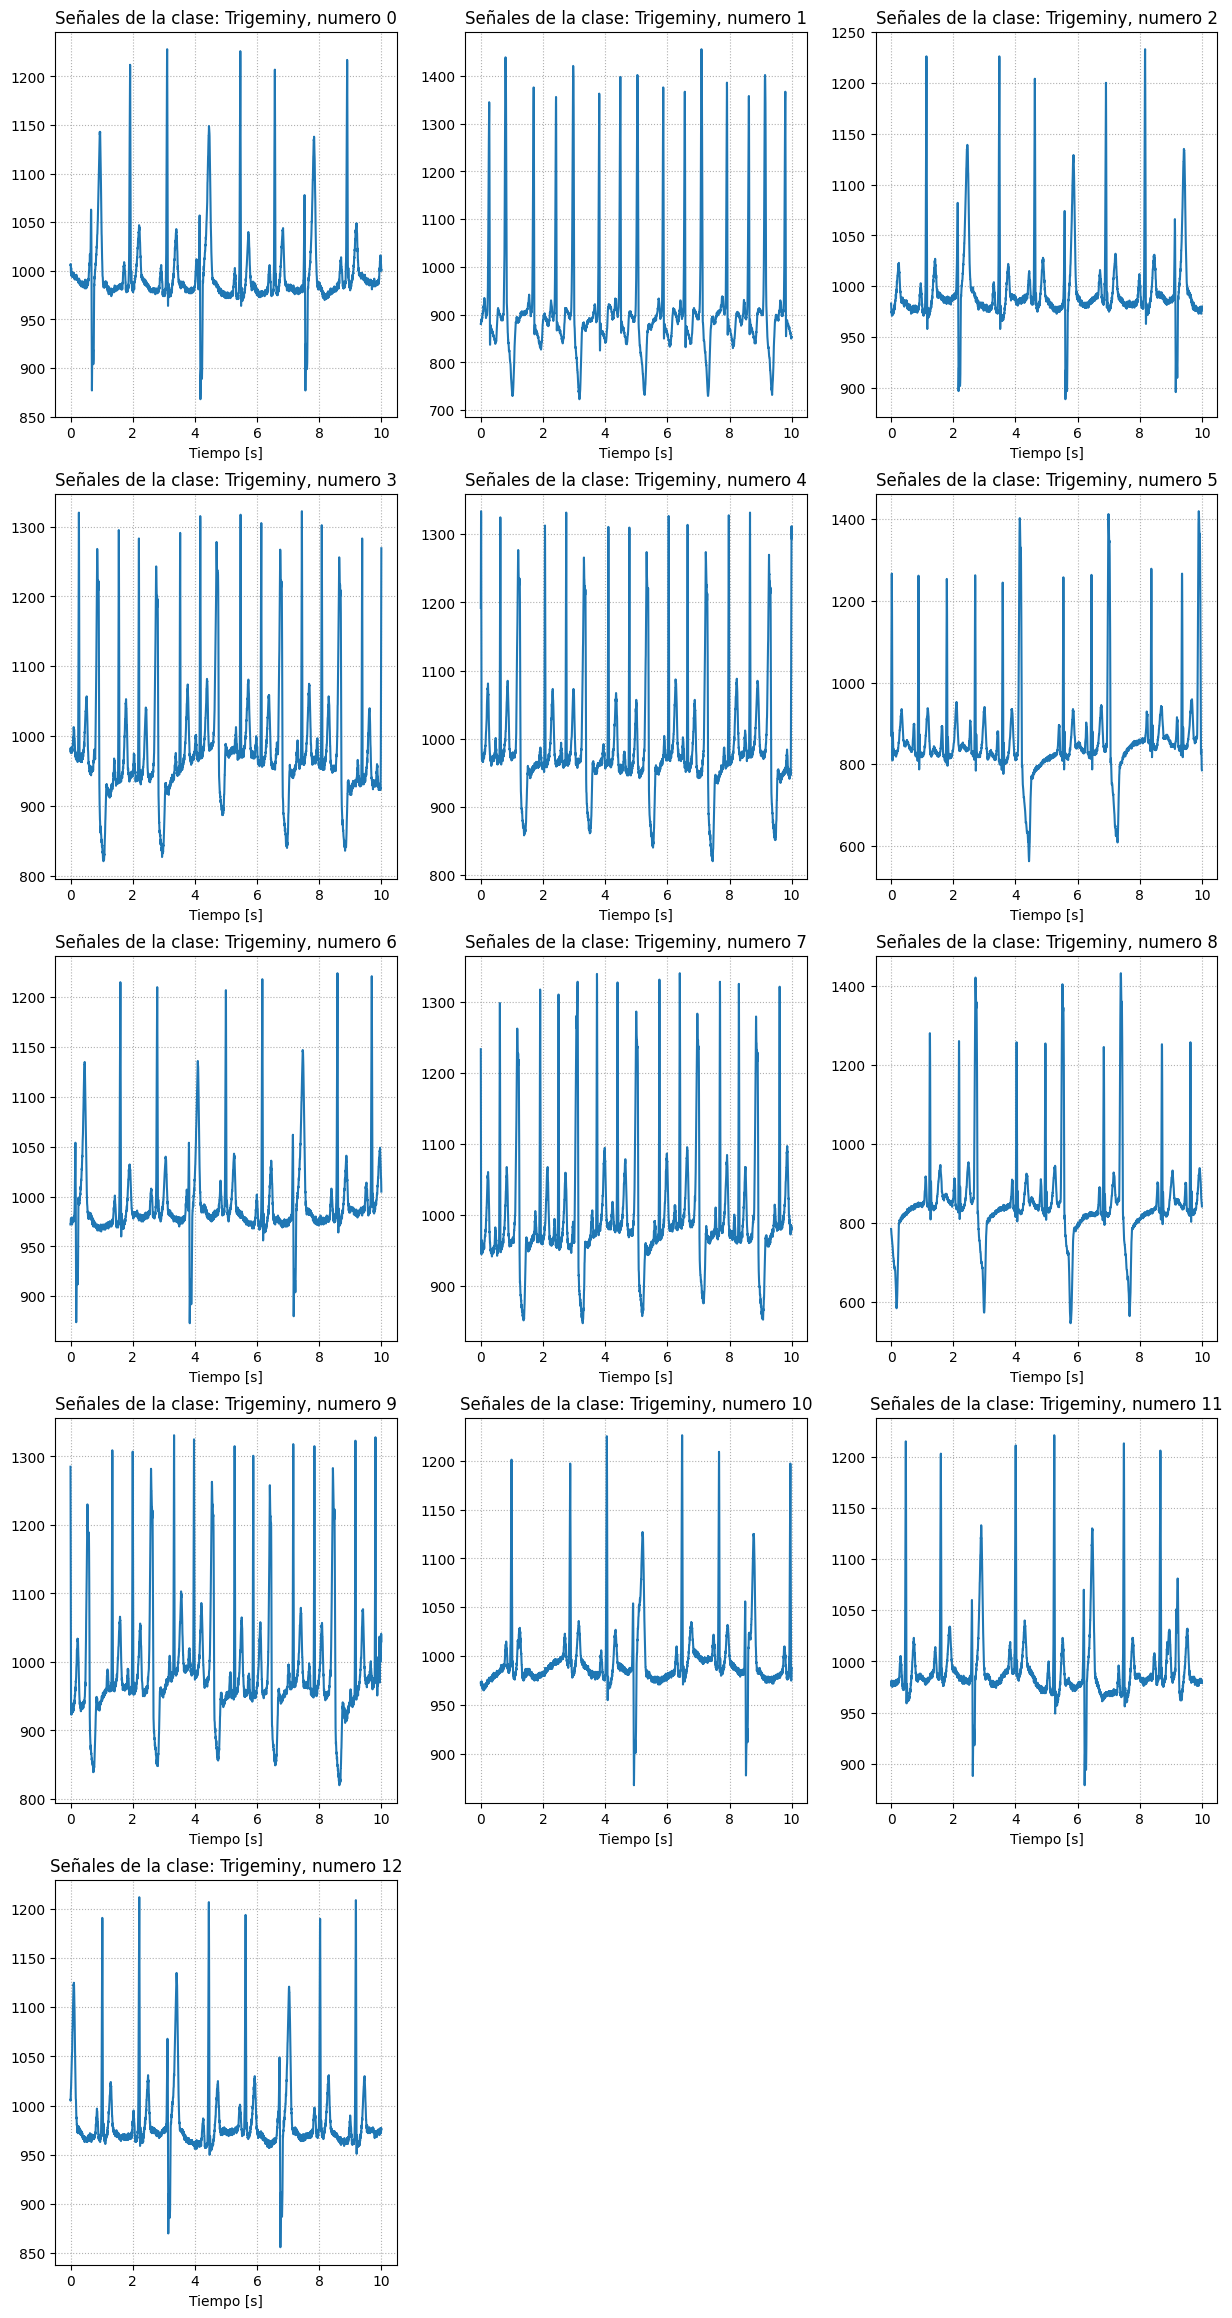

In [6]:
pos = 0

plt.figure(figsize=(15,35))
#plt.suptitle()
print("Señales de {}\n".format(class_selected))
#plt.tight_layout(pad=10.0, h_pad=10.0, w_pad=20.0)  

for i, name in enumerate(json_db[class_selected]):
    plt.subplot(6,3,i+1)
    n = np.arange(0, len(name))
    t = n * (1/360)  # frecuencia de muestreo 360
    plt.xlabel("Tiempo [s]")
    #plt.ylabel("Amplitud [mV]")
    plt.plot(t, name)
    plt.grid(ls=":")
    plt.title("Señales de la clase: {}, numero {}".format(class_selected, i))

plt.show()
#plt.savefig('../resultados/imagenes/ecg_dominio_tiempo.png')

Quitar DC simple

el dataset indica gain = 200 adu/mV, entonces la conversión oficial es:

$$x_mV
=
(
x_digital
−
baseline
)/
200

$$	​


In [7]:
from scipy.fft import fft, fftfreq
from scipy.signal import welch, lfilter
from scipy.signal import butter, lfilter

# def butter_bandpass(lowcut, highcut, fs, order=5):
#     nyq = 0.5 * fs
#     low = lowcut / nyq
#     high = highcut / nyq
#     b, a = butter(order, [low, high], btype='band')
#     return b, a


# def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
#     b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#     y = lfilter(b, a, data)
#     return y

#lfilter(b,a, )

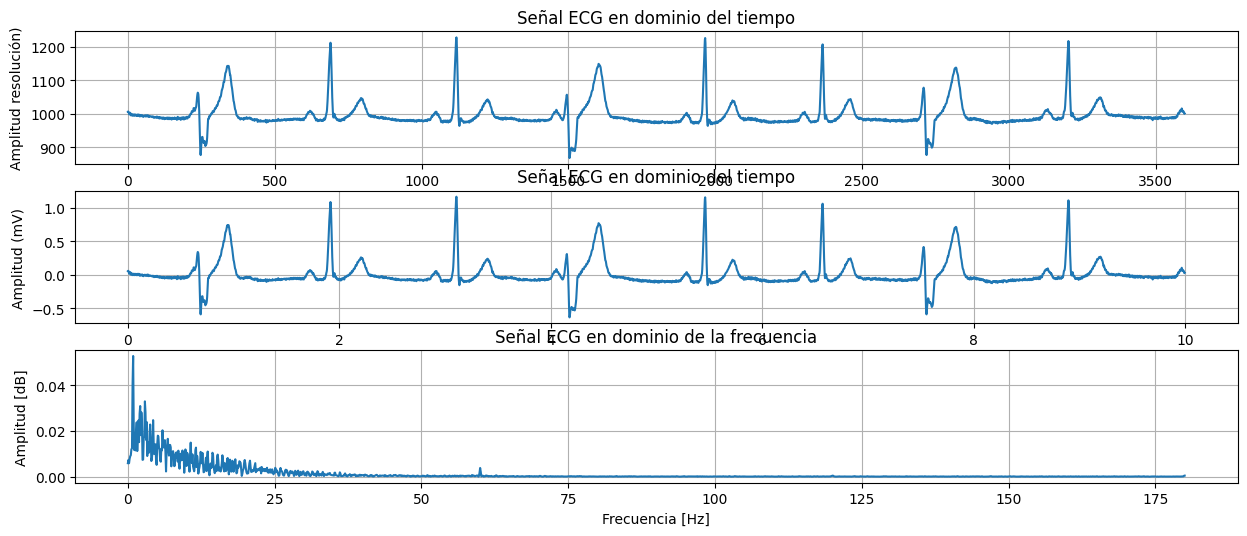

In [8]:
x = json_db[class_selected][0]

#conversion a mV
def voltaje_mv(x):
    x_mv = (x-1024) / 200
    return (x_mv- np.mean(x_mv)) # centrar la señal


#x_mv = (x-1024) / 200
#x_mv = x_mv - np.mean(x_mv) # centrar la señal
#x_mv = x_mv / np.max(np.abs(x_mv)) # normalización

n = np.arange(0, len(x))
t= n * (1/360)


plt.figure(figsize=(15,10))
#plt.tight_layout(h_pad=5.0)
plt.subplot(5,1,1)
plt.plot(x)
plt.title("Señal ECG en dominio del tiempo")
plt.xlabel("Muestras")
plt.ylabel("Amplitud resolución)")
plt.grid()

plt.subplot(5,1,2)
plt.plot(t, voltaje_mv(x))
plt.title("Señal ECG en dominio del tiempo")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud (mV)")
plt.grid()

plt.subplot(5,1,3)
plt.magnitude_spectrum(voltaje_mv(x), Fs=360)
plt.title("Señal ECG en dominio de la frecuencia")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud [dB]")
plt.grid()

# b=[0.00021662145046080457, 0.0017329716036864366, 0.0060654006129025285, 0.012130801225805057, 0.015163501532256322, 0.012130801225805057, 0.006065400612902528,0.0017329716036864366 , 0.00021662145046080457 ]
# a= [ 1, -3.5396221897795455, 6.161, -6,561, 4.605, -2.158, 0.648, -0.117, 0.00939]
# filtered_signal = lfilter(b,a,voltaje_mv(x))
# #filtered_signal = butter_bandpass_filter(voltaje_mv(x), 0.1, 50, fs=360, order=18)

# plt.subplot(5,1,4)
# plt.plot(t, filtered_signal)
# plt.title("Señal ECG filtrada en dominio del tiempo")
# plt.xlabel("Tiempo [s]")
# plt.ylabel("Amplitud (mV)")
# plt.grid()

plt.show()

## Exportar la base de datos mejorada

In [9]:
json_db2 = {}
for i in json_db.keys():
    json_db2[i] = voltaje_mv(json_db[i])

json_db2

{'NSR': array([[-0.06451476, -0.05951476, -0.02951476, ...,  0.13548524,
          0.13048524,  0.11548524],
        [ 0.24548524,  0.25048524,  0.24048524, ...,  0.34048524,
          0.33548524,  0.31548524],
        [ 0.13048524,  0.12548524,  0.11048524, ..., -0.20451476,
         -0.20451476, -0.20451476],
        ...,
        [-0.46451476, -0.46451476, -0.46451476, ..., -0.59451476,
         -0.58951476, -0.58951476],
        [-0.53451476, -0.51451476, -0.53451476, ..., -0.51451476,
         -0.44451476, -0.40451476],
        [ 0.51548524,  0.50548524,  0.50548524, ...,  0.21048524,
          0.20048524,  0.18548524]], shape=(283, 3600)),
 'VT': array([[ 0.10787069,  0.08787069,  0.08787069, ...,  0.01287069,
         -0.00212931,  0.01787069],
        [-0.31212931, -0.29712931, -0.27212931, ...,  0.82787069,
          0.84787069,  0.86787069],
        [ 0.01287069,  0.00787069,  0.00287069, ...,  0.04787069,
          0.06787069,  0.10287069],
        ...,
        [ 0.17287069, 

In [10]:
import pickle

path_db2 = "ECG_DATASET/dataset_ekg.pkl"

with open(path_db2, "wb") as f:
    pickle.dump(json_db2, f)


FFT de DATABASE



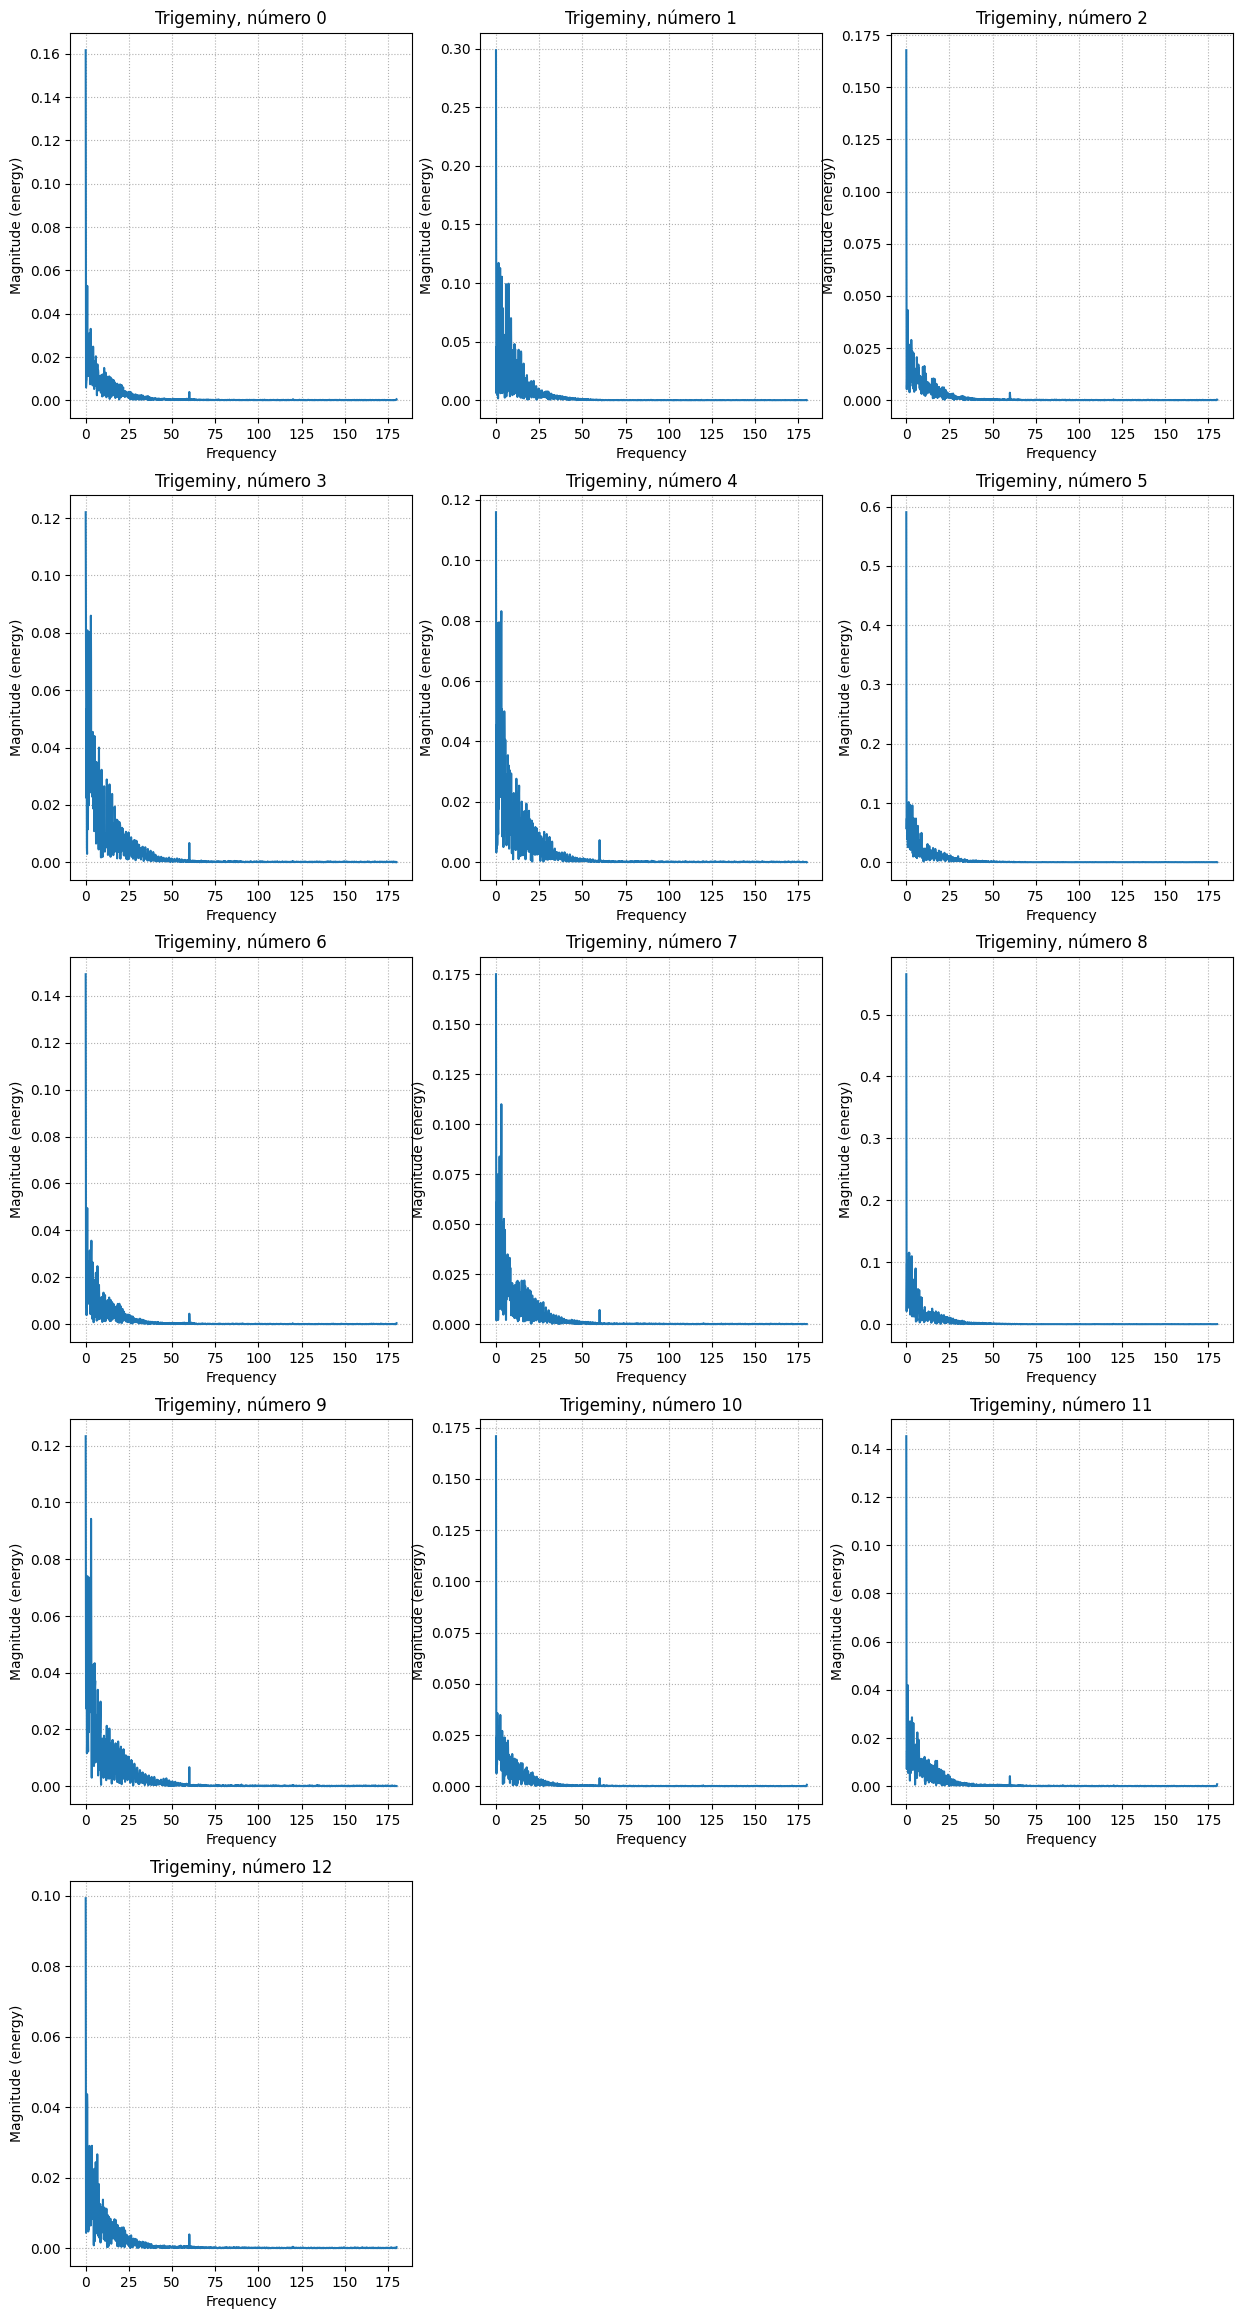

In [11]:
pos = 0
fs = 360

plt.figure(figsize=(15,35))
print("FFT de DATABASE\n")
#plt.tight_layout()

for i, signal in enumerate(json_db2[class_selected]):
    plt.subplot(6,3,i+1)
    #plt.plot(dict_labels[name][pos])
    plt.magnitude_spectrum(signal, Fs=fs, color='C0')
    #plt.xlim(0.01, 50)
    #plt.ylim(0, 50)
    plt.grid(ls=":")
    #plt.axhline(0, color='black', lw=0.5)
    plt.title(class_selected+", número {}".format(i))

plt.show()

STFT de DATABASE



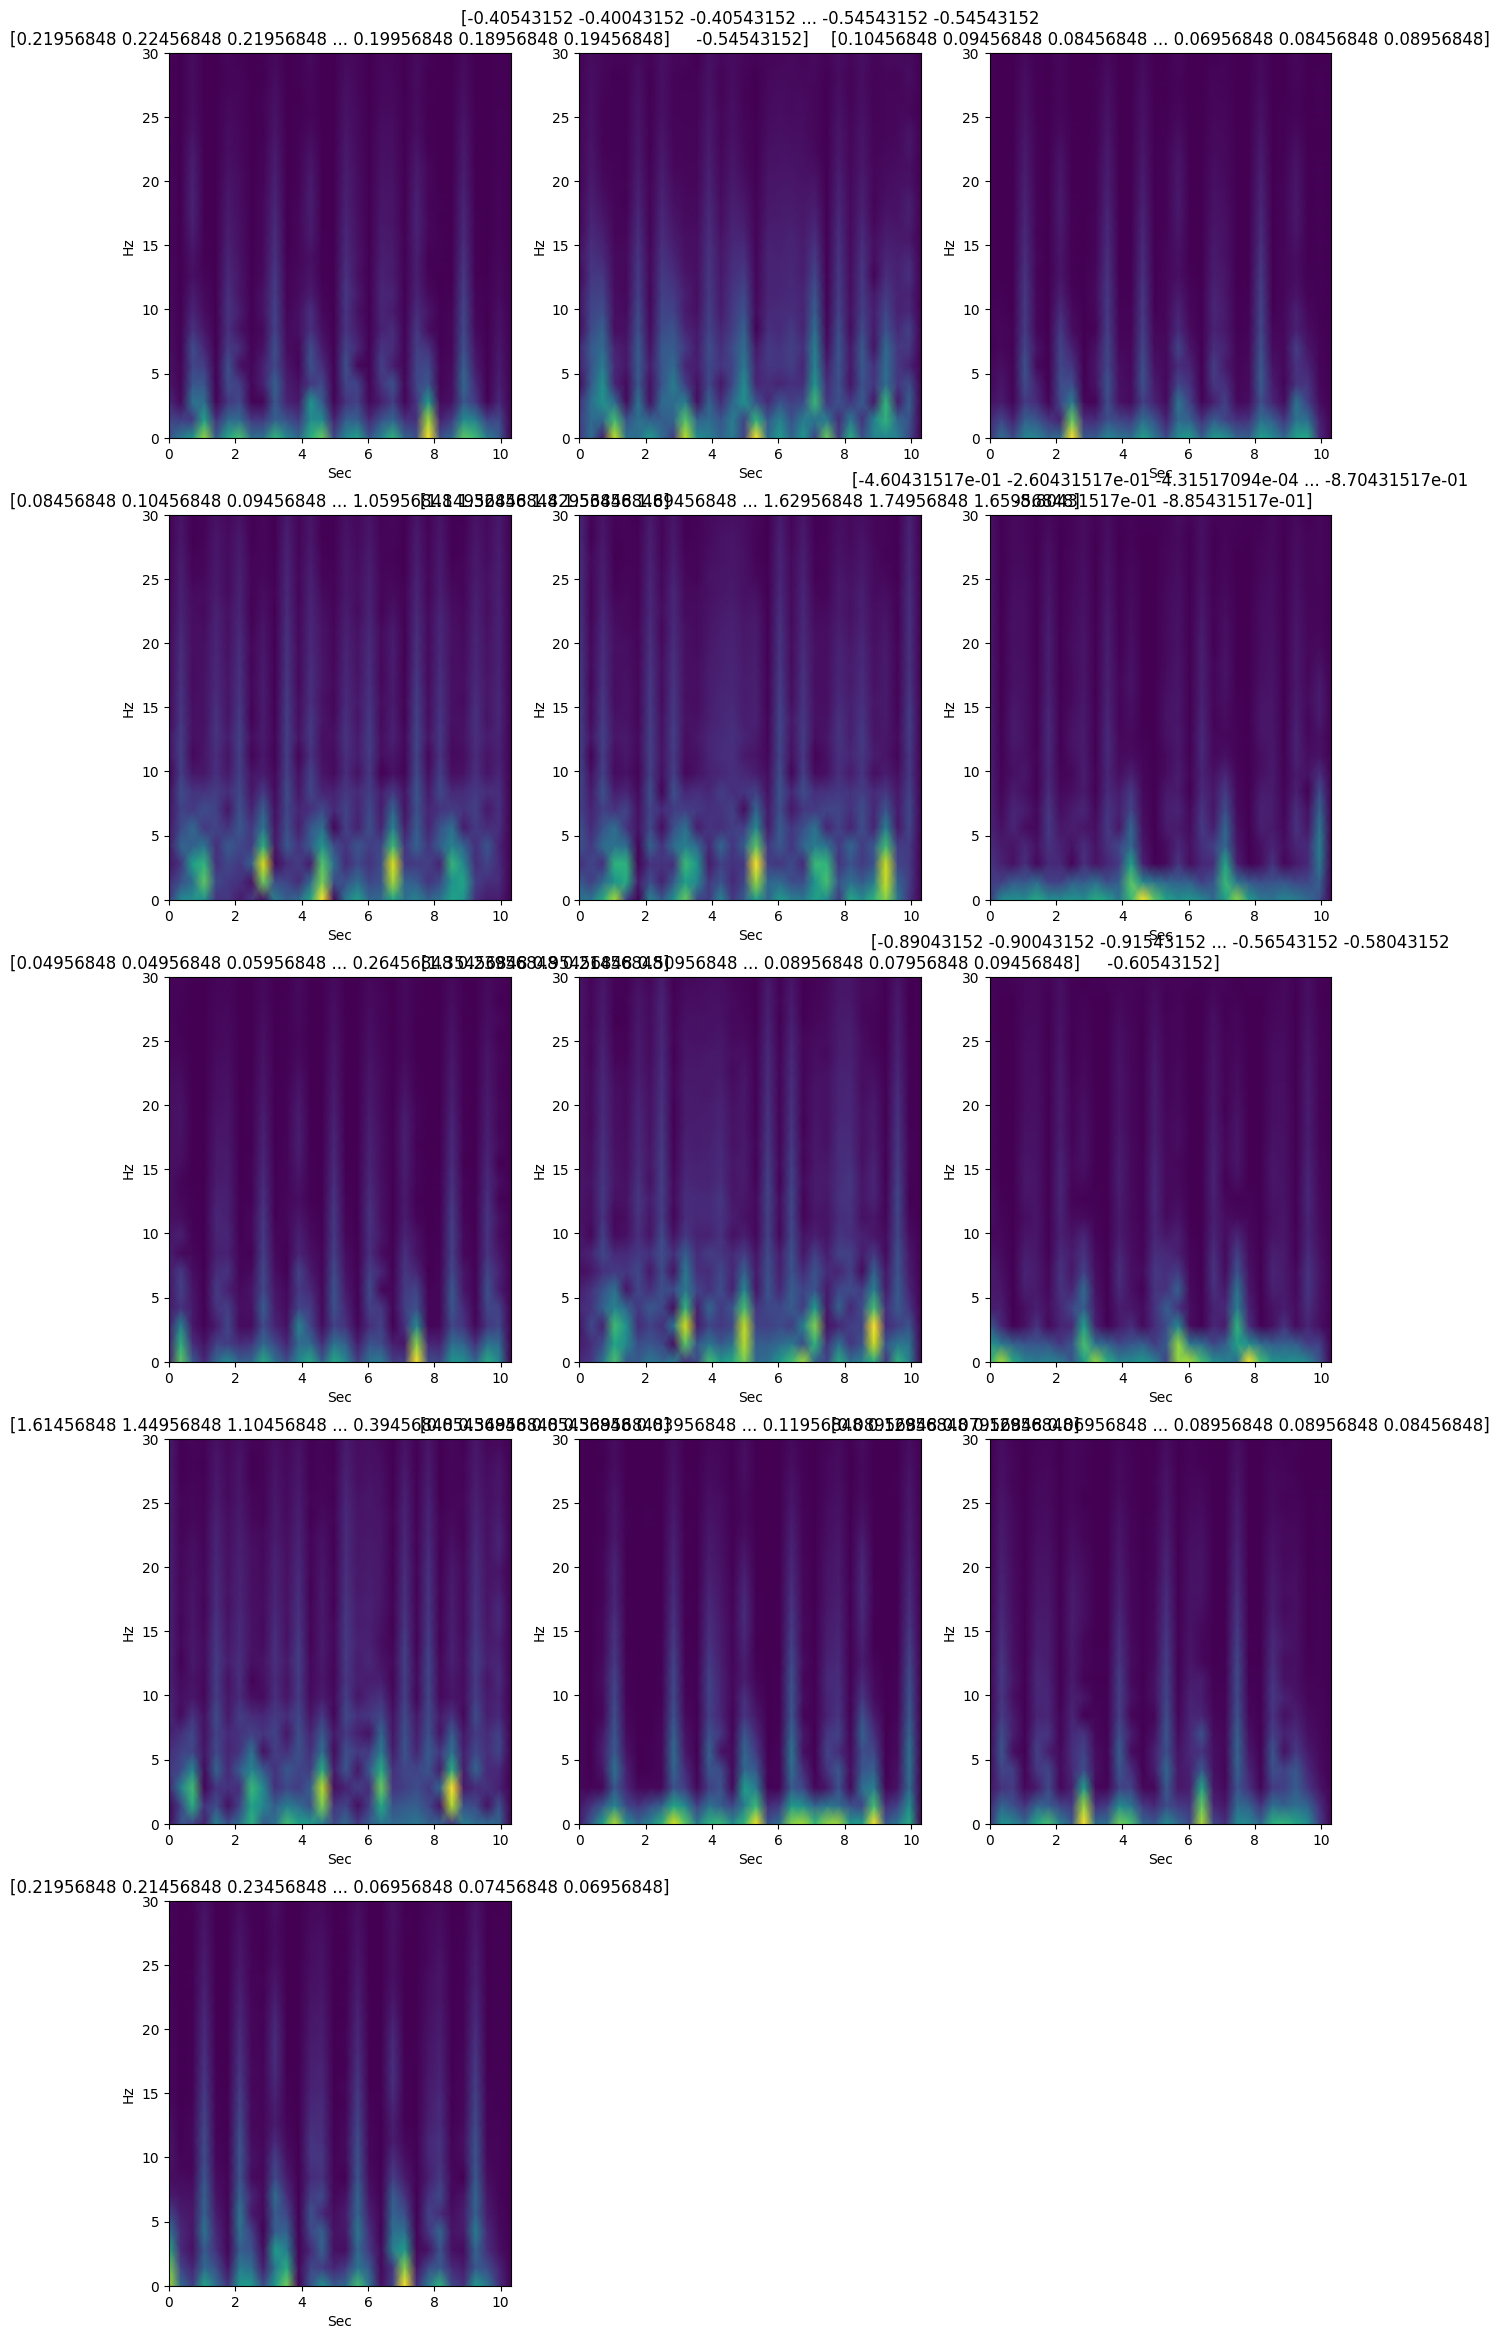

In [14]:
from scipy.signal import stft

pos = 0
fs = 360

plt.figure(figsize=(15,35))
print("STFT de DATABASE\n")
#plt.tight_layout()

for i, name in enumerate(json_db2[class_selected]):
    plt.subplot(6,3,i+1)
    #plt.plot(dict_labels[name][pos])
    #plt.magnitude_spectrum(dict_labels[name][pos], Fs=fs, color='C0')
    #plt.xlim(0.1, 50)
    #plt.ylim(0, 50)
    #plt.grid(ls=":")
    #plt.axhline(0, color='black', lw=0.5)
    x = name
    f, t, Zxx = stft(x, fs=fs, nperseg=256)

    plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
    plt.ylabel('Hz')
    plt.xlabel('Sec')
    plt.ylim(0, 30)
    plt.title(name)

plt.show()